In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

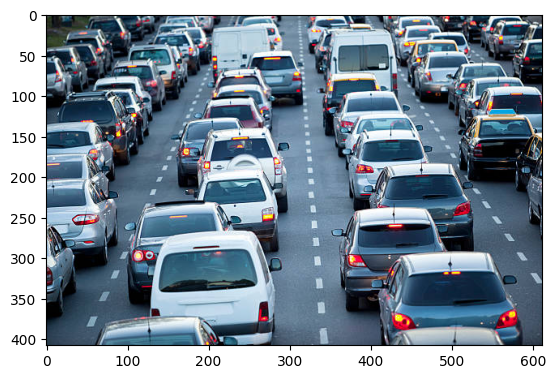

In [5]:
img = cv2.imread('cars.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
pixels = image.reshape(-1, 3)
K=3

In [35]:
mean = np.mean(pixels, axis=0)

std= np.ones(K)/K
pixels = (pixels - mean)/ std

In [36]:
n, d = pixels.shape
pi= np.ones(K) /K
mu = np.random.rand(K, d)
sigma = np.array([np.eye(d)] * K)

In [37]:
def e_step(pixels, pi, mu, sigma):
  N, _ = pixels.shape
  gamma = np.zeros((N, K))
  for k in range(K):
    pdf = multivariate_normal.pdf(pixels, mu[k], sigma[k])
    if np.isnan(pdf).any() or np.isinf(pdf).any():
      print('Warning pdf contains Nan or Inf')
    gamma[:, k] = pi[k] * pdf
  gamma_sum = gamma.sum(axis=1, keepdims=True)
  gamma_sum[gamma_sum == 0] = 1e-10
  gamma /= gamma_sum
  return gamma


In [38]:
def m_step(pixels, gamma):
  N, d = pixels.shape
  N_k = gamma.sum(axis=0)
  pi = N_k / N
  mu = np.dot(gamma.T, pixels)/ N_k[:, np.newaxis]
  sigma = np.zeros((K, d, d))
  for k in range(K):
    diff = pixels - mu[k]
    sigma[k] = np.dot(gamma[:, k] * diff.T, diff) / N_k[k]
  return pi, mu, sigma

In [39]:
def log_likelihood(pixels, pi, mu, sigma):
  N, _ = pixels.shape
  ll = np.zeros(N)
  for k in range(K):
    pdf = multivariate_normal.pdf(pixels, mu[k], sigma[k])
    ll += pi[k] * pdf
  return np.sum(np.log(ll+1e-10))

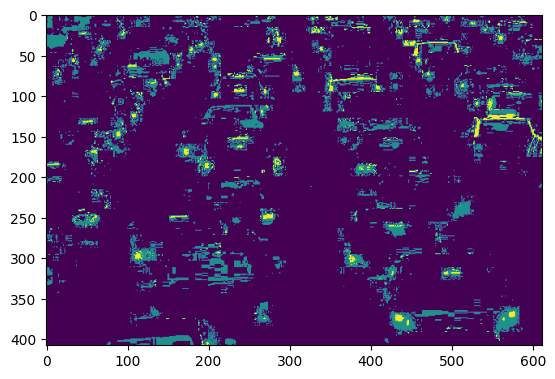

In [40]:
tol = 1e-6
max_iter = 1000
log_likelihoods=[]

for i in range(max_iter):
  gamma = e_step(pixels, pi, mu, sigma)
  pi, mu, sigma = m_step(pixels, gamma)
  ll = log_likelihood(pixels, pi, mu, sigma)
  log_likelihoods.append(ll)
  if i > 0 and np.abs(ll - log_likelihoods[-2]) < tol:
    break


labels = np.argmax(gamma, axis=1)
segmented_img= labels.reshape(image.shape[0], image.shape[1])
plt.imshow(segmented_img)
plt.show()

In [46]:
img_copy = np.zeros((image.shape[0], image.shape[1], 3))
for i in range(K):
  img_copy[:,:,i][segmented_img==i]= 1


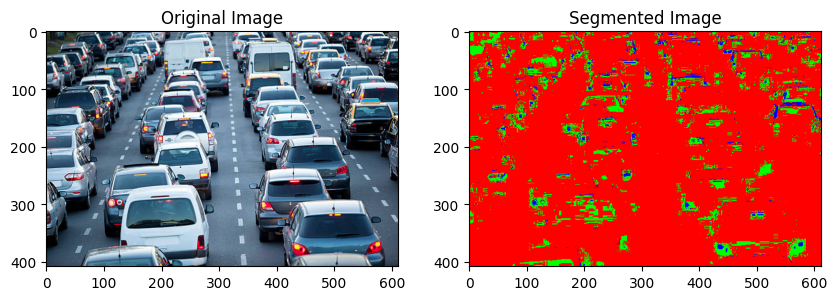

In [47]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(image)
plt.subplot(1,2,2)
plt.title('Segmented Image')
plt.imshow(img_copy)
plt.show()